# Titanic Data Investigation#

_ by [Jens Laufer](mailto:jenslaufer@gmail.com) _

## Introduction

RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning of 15 April 1912, after colliding with an iceberg during her maiden voyage from Southampton to New York City. Of the 2,224 passengers and crew aboard, more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. The largest ship afloat at the time it entered service, the RMS Titanic was the second of three Olympic class ocean liners operated by the White Star Line, and was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.
Under the command of Edward Smith, who went down with the ship, Titanic carried some of the wealthiest people in the world, as well as hundreds of emigrants from Great Britain and Ireland, Scandinavia and elsewhere throughout Europe seeking a new life in North America. A high-power radiotelegraph transmitter was available for sending passenger "marconigrams" and for the ship's operational use. Although Titanic had advanced safety features such as watertight compartments and remotely activated watertight doors, there were not enough lifeboats to accommodate all of those aboard due to outdated maritime safety regulations. Titanic only carried enough lifeboats for 1,178 people—slightly more than half of the number on board, and one third of her total capacity.

After leaving Southampton on 10 April 1912, Titanic called at Cherbourg in France and Queenstown (now Cobh) in Ireland before heading west to New York. On 14 April, four days into the crossing and about 375 miles (600 km) south of Newfoundland, she hit an iceberg at 11:40 p.m. ship's time. The collision caused the ship's hull plates to buckle inwards along her starboard side and opened five of her sixteen watertight compartments to the sea; the ship gradually filled with water. Meanwhile, passengers and some crew members were evacuated in lifeboats, many of which were launched only partially loaded. A disproportionate number of men were left aboard because of a "women and children first" protocol for loading lifeboats. At 2:20 a.m., she broke apart and foundered—with well over one thousand people still aboard. Just under two hours after Titanic sank, the Cunard liner RMS Carpathia arrived at the scene, where she brought aboard an estimated 705 survivors.

The disaster was greeted with worldwide shock and outrage at the huge loss of life and the regulatory and operational failures that had led to it. Public inquiries in Britain and the United States led to major improvements in maritime safety. One of their most important legacies was the establishment in 1914 of the International Convention for the Safety of Life at Sea (SOLAS), which still governs maritime safety today. Additionally, several new wireless regulations were passed around the world in an effort to learn from the many missteps in wireless communications—which could have saved many more passengers.
The wreck of Titanic, first discovered over 70 years after the sinking, remains on the seabed, split in two and gradually disintegrating at a depth of 12,415 feet (3,784 m). Since her discovery in 1985, thousands of artefacts have been recovered and put on display at museums around the world. Titanic has become one of the most famous ships in history; her memory is kept alive by numerous works of popular culture, including books, folk songs, films, exhibits, and memorials. [1]


## Questions on data ##

   - Was it more likely to survive as woman or a child?
   - Was ist more likely to survive as first class passenger, because of the socioeconomic status?
   - Was ist more likely to survive on the different location of embarkments?
   - Was ist more like to survive as a family member or a person on his own?   
   - Was ist more like to survive in certain Age groups?   

In [1199]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.api as sms
from scipy import stats

filename = 'titanic-data.csv'
titanic_df = pd.read_csv(filename)

## About the dataset ##

### Structure of dataset ###

|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked
|-|-|-|-|-|-|-|-|-|-|-|
|Passenger Id|Survival (0 = No; 1 = Yes)|Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)|Name|Sex|Age|Number of Siblings/Spouses Aboard|Number of Parents/Children Aboard|Ticket Number|Passenger Fare|Cabin|Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

#### Example data ####

In [1200]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Problems in the dataset ###

In [1201]:
titanic_df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

Not for all passengers the 'Age' is available

Not for all passengers 'Cabin' available.

Not for all passengers 'Embarked' is available.

##  Data Analysis: Data Cleaning and Wrangling ##

I am removing the columns 'Name', 'Ticket' and 'Fare'  as I do not need them to answer my questions.

I am extracting the deck from the cabin and remove the 'Cabin' column. 

I am extracting a new field 'IsFamilyMember' that indicates, if someone is a family member based on the 'Parch'  and 'SibSp'. I am removing those two fields afterwards.

I am extracting different age groups and put the result into a new field 'AgeGroups' and remove the 'Age' column afterwards.

For convience I am also adding a new column 'IsChild' although is information available in 'AgeGroups'

In [1202]:
del titanic_df['Name']
del titanic_df['Ticket']
del titanic_df['Fare']

In [1203]:
# I change the embarkement location to a full name
def get_embarked_fullname(row):
    embarked = row['Embarked']
    if embarked == 'S':
        return 'Southampton'
    elif embarked == 'C':
        return 'Cherbourg'
    elif embarked == 'Q':
        return 'Queenstown'
    else:
        return embarked
    
# I add a new column to the dataset
titanic_df['Embarked'] = titanic_df.apply(get_embarked_fullname, axis=1)

In [1204]:
# I extract the the deck from the cabin; first letter identifies the deck.
def get_deck(row):
    if row['Cabin'] == row['Cabin']:
        return row['Cabin'][0:1]
    return row['Cabin']
    
# I add a new column to the dataset
titanic_df['Deck'] = titanic_df.apply(get_deck, axis=1)

del titanic_df['Cabin']

In [1205]:
# Definition: A passenger is a family member if either SibSp or Parch is > 0
def is_family_member(row):
    return not(row['Parch'] == 0 and row['SibSp'] == 0)

# I add a new column to the dataset
titanic_df['IsFamilyMember'] = titanic_df.apply(is_family_member, axis=1)

# I remove the Parch and SibSp columns
del titanic_df['Parch']
del titanic_df['SibSp']

In [1206]:
# I extract age groups 
def age_group(row):
    age = row['Age']
    if age < 1:
        return 'Infant'
    elif age >= 1 and age <= 9:
        return 'Child'
    elif age > 9 and age <= 19:
        return 'Adolescent'
    elif age > 19 and age <= 45:
        return 'Adult'
    elif age > 45 and age <= 60:
        return 'Middle Age'
    elif age > 60:
        return 'Senior'
    else:
        return age

titanic_df['AgeGroup'] = titanic_df.apply(age_group, axis=1)

In [1207]:
# I extract as well, if a passenger is is a child 
def is_child(row):
    age = row['Age']
    if age <= 14:
        return True
    elif age > 14:
        return False
    else:
        return age

titanic_df['IsChild'] = titanic_df.apply(is_child, axis=1)

In [1208]:
# I delete the Age column
del titanic_df['Age']

#### Example of the Wrangled Data ####

In [1209]:
titanic_df.head(10)

,PassengerId,Survived,Pclass,Sex,Embarked,Deck,IsFamilyMember,AgeGroup,IsChild
0,1,0,3,male,Southampton,NaN,True,Adult,False
1,2,1,1,female,Cherbourg,C,True,Adult,False
2,3,1,3,female,Southampton,NaN,False,Adult,False
3,4,1,1,female,Southampton,C,True,Adult,False
4,5,0,3,male,Southampton,NaN,False,Adult,False
5,6,0,3,male,Queenstown,NaN,False,NaN,NaN
6,7,0,1,male,Southampton,E,False,Middle Age,False
7,8,0,3,male,Southampton,NaN,True,Child,True
8,9,1,3,female,Southampton,NaN,True,Adult,False
9,10,1,2,female,Cherbourg,NaN,True,Adolescent,True


In [1210]:
titanic_df.describe()

,PassengerId,Survived,Pclass
count,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642
std,257.353842,0.486592,0.836071
min,1.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000
50%,446.000000,0.000000,3.000000
75%,668.500000,1.000000,3.000000
max,891.000000,1.000000,3.000000


## Data Analysis: Answering the questions ##

** Survival Probability of all passengers in the dataset: **

In [1211]:
titanic_df['Survived'].mean()

0.3838383838383838

###  Was it more likely to survive as a woman or a child? ###

#### Hypothesis

$H_0$: Gender does not have an impact on the survival probabilty


$H_A$: Gender does have an impact on the survival probabilty

I chose $\alpha = .05$

Survival rate by sex:

In [1212]:
titanic_df.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

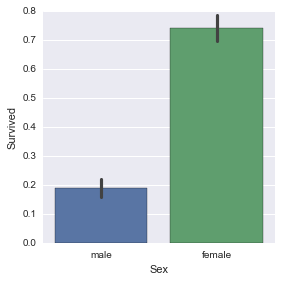

In [1213]:
%matplotlib inline
sns.factorplot(x = 'Sex', y = 'Survived', data = titanic_df, kind = 'bar')

The survival probability of the female passengers (74.2%) in the dataset is higher than the overall survival rate (38.4%) and higher than the survival rate of the male passengers (18.9%). 

In [1214]:
### Hypothesis Test

In [1215]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['Sex'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p

260.717020167
1.19735706278e-58


$\chi^2 = 260.717020167$

$p = 1.19735706278e-58$

I reject  $H_0$  as p < .0001. Gender has a great impact on the survival probability.

#### Hypothesis

$H_0$: Being a child does not have an impact on the survival probabilty


$H_A$: Being a child does have an impact on the survival probabilty

I chose $\alpha = .05$

In [1216]:
titanic_df.groupby('IsChild')['Survived'].mean()

IsChild
False    0.384615
True     0.584416
Name: Survived, dtype: float64

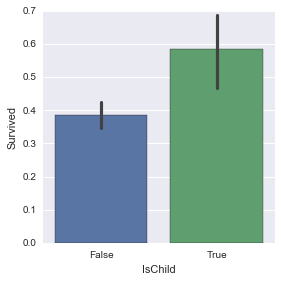

In [1217]:
%matplotlib inline
sns.factorplot(x = 'IsChild', y = 'Survived', data = titanic_df, kind = 'bar')

The survival probability of children (58.4%) was higher than the rest of the passengers (38.4%) and the overall survival rate(38.4%).

##### Hyphothesis Test

In [1218]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['IsChild'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p

10.5566027499
0.00115773781909


$\chi^2 = 10.5566027499$

$p = 0.00115773781909$

I reject $H_0$ as p < .01. Being a child has an impact on the survival probability.

#### Result ####

On the Titanic existed most probably a ["Women and children first" code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first) when the ship was evacuated as the survival probability was higher for woman and children.

### Was ist more likely to survive as first class passenger, because of the socioeconomic status? ###

Survival rate by passenger class

In [1219]:
titanic_df.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

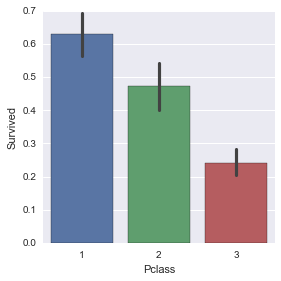

In [1220]:
%matplotlib inline
sns.factorplot(x = 'Pclass', y ='Survived', data = titanic_df, kind = 'bar')

The survival probabilty is higher for the second and third class.

Were the first class passengers rescued, because of their socioeconomic status or were other factors responsible for the higher survival probability?

   * Have the first class cabins been on top of the ship and were the passengers of these cabins rescued first?
   * Have there been more female passengers or children in the first class?

#### Have the first class cabins been on top of the ship and were the passengers of these cabins rescued first?

##### Where are the cabins of each passenger class located?

###### Titanic deck layout

![Titanic deck layout](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/400px-Titanic_cutaway_diagram.png "Titanic deck layout")

In [1221]:
# I drop all NaN entries in the Deck subset, I also drop the entry with the deck 'T' as 
# there was no deck 'T'
deck_titanic_df = titanic_df[titanic_df.Deck != 'T'].dropna(subset=['Deck'])

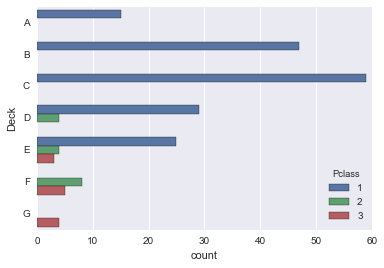

In [1222]:
%matplotlib inline
sns.countplot(y="Deck", hue="Pclass", data=deck_titanic_df.sort_values(by='Deck'))

In [1223]:
deck_titanic_df.groupby(['Pclass']).Survived.count()

Pclass
1    175
2     16
3     12
Name: Survived, dtype: int64

I will ignore the deck information for the second for the third class as there are not enough data available for these classes and the cabins of the first class passengers were located on the decks A-E. With this information I should be able to evaluate, if the ship was rescued upsite down.

In [1224]:
deck_titanic_df[deck_titanic_df['Pclass'] == 1].groupby(['Pclass','Deck']).Survived.mean().sort_values()

Pclass  Deck
1       A       0.466667
        C       0.593220
        E       0.720000
        B       0.744681
        D       0.758621
Name: Survived, dtype: float64

The cabins of the first class were located on the decks A-E. If there would have been a rescue plan from the top to the bottom there would be a higher survival on deck A than e.g. on deck D. I can actually see that the survival probability on deck D and E was higher than on deck A. It seems that the passengers on top of ship were not rescued first.

In [1225]:
titanic_df[titanic_df['Sex'] == "female"].groupby(['Sex', 'Pclass']).Survived.count() / titanic_df.groupby(['Sex']).Survived.count()

Sex     Pclass
female  1         0.299363
        2         0.242038
        3         0.458599
Name: Survived, dtype: float64

In [1226]:
titanic_df[titanic_df['IsChild'] == True].groupby(['IsChild','Pclass']).Survived.count() / titanic_df.groupby(['IsChild']).Survived.count()

IsChild  Pclass
True     1         0.064935
         2         0.246753
         3         0.688312
Name: Survived, dtype: float64

The proportion of children and female passengers in the third class was much higher that in the first class.

#### Result ####

The Survival probability of first class passengers was the highest (63.0%). On the other hand the third class had a very low probability of surviving the disaster (24.2%). This is most probably due the fact, that first class passengers where rescued because of their socioeconomic status and not due the fact that there were more children and woman in the first class or that the first class cabins were on the top of the ship and these decks were rescued first.


### Was ist more likely to survive on the different location of embarkments? ###

#### Hypothesis

$H_0$: Embarkment location does not have an impact on the survival probabilty


$H_A$: Embarkment location does have an impact on the survival probabilty
    

I chose $\alpha = .05$

Survival rate by embarkement location:

In [1227]:
titanic_df.groupby('Embarked')['Survived'].mean()

Embarked
Cherbourg      0.553571
Queenstown     0.389610
Southampton    0.336957
Name: Survived, dtype: float64

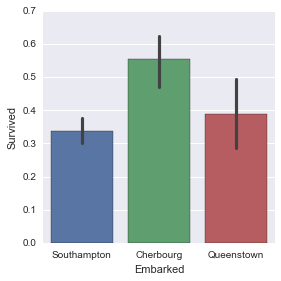

In [1228]:
%matplotlib inline
sns.factorplot(x = 'Embarked', y = 'Survived', data = titanic_df, kind = 'bar')

#### Hypothesis Test

In [1229]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['IsChild'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p    

10.5566027499
0.00115773781909


$\chi^2 = 10.5566027499$

$p = 0.00115773781909$

I reject $H_0$ as p < .01. Embarkment has an impact on the survival probability.

The survival probability was higher for passengers for who boarded in Cherbourg.

What factors might be responsible for that:

   - Were there more first class passengers in Cherbourg?
   - Was proportion of children and woman higher in Cherbourg?

Passengers by embarkment location and class:

In [ ]:
titanic_df.groupby(['Embarked','Pclass',]).size() / titanic_df.groupby('Embarked').size()

Embarked     Pclass
Cherbourg    1         0.505952
             2         0.101190
             3         0.392857
Queenstown   1         0.025974
             2         0.038961
             3         0.935065
Southampton  1         0.197205
             2         0.254658
             3         0.548137
dtype: float64

In [ ]:
%matplotlib inline
sns.countplot(y="Embarked", hue="Pclass", data=titanic_df)

The proportion of first class passengers was higher in Cherbourg than in Southampton and Queenstown.

In [ ]:
titanic_df[titanic_df['IsChild'] == True].groupby(['Embarked','IsChild',]).size() / titanic_df.groupby('Embarked').size()

In [ ]:
%matplotlib inline
sns.countplot(y="Embarked", hue="IsChild", data=titanic_df)

The proportion of children was about the same in Cherbourg, Queenstown and Southampton

In [ ]:
titanic_df[titanic_df.Sex == 'female'].groupby(['Embarked','Sex',]).size() / titanic_df.groupby('Embarked').size()

In [ ]:
%matplotlib inline
sns.countplot(y="Embarked", hue="Sex", data=titanic_df)

The proportion of woman was about the same in Cherbourg, Queenstown and Southampton

#### Result ####

The probabilty of surviving the titanic disaster was highest in case someone boarded in Cherbourg.
This is most probably due the fact that the proportion of first class passengers from Cherbourg was higher than in Southampton and Queenstown and not due the fact that in Cherborug the propportion of woman or children were higher.

### Was ist more like to survive as a family member or a person on his own? ###

#### Hypothesis

$H_0$: Being a family member does not have an impact on the survival probabilty


$H_A$:  Being a family member does have an impact on the survival probabilty
    

I chose $\alpha = .05$

In [ ]:
titanic_df.groupby('IsFamilyMember')['Survived'].mean()

In [ ]:
titanic_df.groupby(['Pclass','IsFamilyMember'])['Survived'].mean()

In [ ]:
%matplotlib inline
sns.factorplot(x = 'IsFamilyMember', y ='Survived', data = titanic_df, kind = 'bar')

#### Hypothesis Test

In [ ]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['IsFamilyMember'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p   

$\chi^2 = 36.0005144677$

$p = 1.97265438465e-09$

I reject $H_0$ as p < .0001. Being a family member has an impact on the survival probability.

#### Result

The probabilty of surviving the Titanic disaster was higher as member of a family than a person on his own in the first and second class. This is most probably also due the ["Women and children first" code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first). In the third class the chance to survive the titanic disaster for person on his own was about the same.

### Survival by Age Group

#### Hypothesis

$H_0$: Age Group does not have an impact on the survival probabilty


$H_A$: Age Group does have an impact on the survival probabilty
    

I chose $\alpha = .05$

In [ ]:
titanic_df.groupby('AgeGroup')['Survived'].count().sort_values()

In [ ]:
titanic_df.groupby('AgeGroup')['Survived'].mean().sort_values()

#### Hypothesis Test

In [ ]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['AgeGroup'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)

print chi2
print p   

$\chi^2 = 19.4949287952$

$p = 0.0015538981547$

I reject $H_0$ as p < .01. Age Group has an impact on the survival probability.

In [ ]:
%matplotlib inline
sns.factorplot(x = 'AgeGroup', y ='Survived', data = titanic_df, kind = 'bar')

In [ ]:
titanic_df[titanic_df.AgeGroup.isin(['Infant', 'Child'])].groupby(['Pclass', 'AgeGroup']).Survived.count()

In [ ]:
titanic_df[titanic_df.AgeGroup.isin(['Infant', 'Child'])].groupby(['Pclass', 'AgeGroup']).Survived.mean()

#### Result

The probability of surviving the Titanic disaster was higher for children than for other age groups. The lowest chance of surviving the sinking of the ship had adults and seniors. 

Interesting is also that all 7 infants survived the disaster, even the 3 infants from the third class. In the first and second class all children survived apart from one child in the first class. She was Loraine Allison: Loraines parents decided to stay on the ship as Loraines brother was missing with his nurse.

## Appendix A

### Sources

[1] [https://en.wikipedia.org/wiki/RMS_Titanic](https://en.wikipedia.org/wiki/RMS_Titanic)

[2] [https://www.encyclopedia-titanica.org/titanic-victim/loraine-allison.html](https://www.encyclopedia-titanica.org/titanic-victim/loraine-allison.html)